In [1]:
import os

# 1. Load data

In [2]:
corpus = []
spam = []

ham_files = [f for f in os.listdir("data/train/ham")]
spam_files = [f for f in os.listdir("data/train/spam")]

for f in ham_files:
    with open("data/train/ham/" + f, 'r', encoding='latin1') as myfile:
        content = myfile.read()
        corpus.append(content)
        spam.append(0)
        
for f in spam_files:
    with open("data/train/spam/" + f, 'r', encoding='latin1') as myfile:
        content = myfile.read()
        corpus.append(content)
        spam.append(1)

Spam is like: [0,0,0 .... 1,1,1]. Cross validation will fail on this distribution. So we need to shuffle corpus and spam identically:

In [3]:
import random
random.seed(42) # without it, shuffle_lists() would make the results unstable.

def shuffle_lists(a, b):
    c = list(zip(a, b))
    random.shuffle(c)
    a, b = zip(*c)
    return a, b

corpus, spam = shuffle_lists(corpus, spam)

# 2. Feature engineering within Transformation Pipeline

We will defines different steps to prepare our data:
- HeaderDeletor: Delete email header.
- UrlsDeletor: Replace urls by URL.
- NumberDeletor Replace numbers by NUMBER .
- Vectorizor: vectorize an email. As option we can also apply downcase and stemming.
- Predictor: Fit a model (Stochastic Gradient Descent) and predict new values.

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer

class HeaderDeletor(BaseEstimator, TransformerMixin):
    def __init__(self, delete_header):
        self.delete_header = delete_header

    def fit(self, X, y):
        return self
    
    def transform(self, X):
        if self.delete_header:
            def delete_header(x):
                try:
                    return x.split("\n\n")[1]
                except IndexError:
                    return ""
                
            return list(map(delete_header, X))
        else:
            return X

In [5]:
import re
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer

class UrlsDeletor(BaseEstimator, TransformerMixin):
    def __init__(self, skip=False):
        self.skip = skip

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.skip:
            return X
        else:
            def replace_urls(x):
                return re.sub(r'http\S+', 'URL', x)
            return list(map(replace_urls, X))

In [6]:
import re, string
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer

class NumberDeletor(BaseEstimator, TransformerMixin):
    def __init__(self, skip=False):
        self.skip = skip

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.skip:
            return X

        def clearup(s):
            return re.sub(r'[0-9]+', 'NUMBER', s)
        
        return list(map(clearup, X))

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.snowball import EnglishStemmer

class Vectorizor(BaseEstimator, TransformerMixin):
    def __init__(self, lowercase=True, skip_stemming=False):
            stemmer = EnglishStemmer()
            analyzer = CountVectorizer().build_analyzer()
            def stemmed_words(doc):
                return (stemmer.stem(w) for w in analyzer(doc))
            if skip_stemming:
                self.vectorizor = CountVectorizer(lowercase=lowercase)
            else:
                self.vectorizor = CountVectorizer(lowercase=lowercase, analyzer=stemmed_words)

    def fit(self, X, y=None):
        self.vectorizor.fit(X)
        return self
    
    def transform(self, X):
        return self.vectorizor.transform(X).toarray()

In [18]:
from sklearn.linear_model import SGDClassifier

class Predictor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.sgd_clf = SGDClassifier(random_state=42)

    def fit(self, X, y=None):
        self.sgd_clf.fit(X, y)
        return self
    
    def transform(self, X):
        return self.sgd_clf.transform(X)
    
    def predict(self, X):
        return self.sgd_clf.predict(X)
    
    def decision_function(self, X):
        return self.sgd_clf.decision_function(X)
    
    def predict_proba(self, X):
        return self.sgd_clf.predict_proba(X)

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin

lowercase = True
delete_header = False
skip_url = True
skip_number = False
skip_stemming = False

pipeline = Pipeline([
        ('header_deletor', HeaderDeletor(delete_header=delete_header)),
        ('url_deletor', UrlsDeletor(skip=skip_url)),
        ('number_deletor', NumberDeletor(skip=skip_number)), 
        ('vectorizer', Vectorizor(lowercase=lowercase, skip_stemming=skip_stemming)),
        ('predictor', Predictor())
    ])

params_grid = [
    {
        'header_deletor__delete_header': [True, False],
        'url_deletor__skip': [True, False],
        'number_deletor__skip': [True, False],
        'vectorizer__lowercase': [True, False],
        'vectorizer__skip_stemming': [True, False]
    }
]

# 3. Fine-tuning of hyperparameters

In [22]:
import numpy as np

grid_search = GridSearchCV(pipeline, params_grid, cv=3, scoring='roc_auc')
grid_search.fit(corpus, spam)

# Display the results of the GridSearch
cvres = grid_search.cv_results_
for mean_score, std_score, params in zip(cvres['mean_test_score'], cvres['std_test_score'], cvres['params']):
    print(np.sqrt(mean_score), np.sqrt(std_score), params)

/Users/geoffroy.gobert/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/Users/geoffroy.gobert/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarni

/Users/geoffroy.gobert/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/Users/geoffroy.gobert/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarni

/Users/geoffroy.gobert/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/Users/geoffroy.gobert/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarni

/Users/geoffroy.gobert/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/Users/geoffroy.gobert/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarni

/Users/geoffroy.gobert/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/Users/geoffroy.gobert/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarni

/Users/geoffroy.gobert/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/Users/geoffroy.gobert/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarni

0.951096452021 0.207708207527 {'header_deletor__delete_header': True, 'number_deletor__skip': True, 'url_deletor__skip': True, 'vectorizer__lowercase': True, 'vectorizer__skip_stemming': True}
0.951096452021 0.207708207527 {'header_deletor__delete_header': True, 'number_deletor__skip': True, 'url_deletor__skip': True, 'vectorizer__lowercase': True, 'vectorizer__skip_stemming': False}
0.951096452021 0.207708207527 {'header_deletor__delete_header': True, 'number_deletor__skip': True, 'url_deletor__skip': True, 'vectorizer__lowercase': False, 'vectorizer__skip_stemming': True}
0.951096452021 0.207708207527 {'header_deletor__delete_header': True, 'number_deletor__skip': True, 'url_deletor__skip': True, 'vectorizer__lowercase': False, 'vectorizer__skip_stemming': False}
0.953742109305 0.208981460492 {'header_deletor__delete_header': True, 'number_deletor__skip': True, 'url_deletor__skip': False, 'vectorizer__lowercase': True, 'vectorizer__skip_stemming': True}
0.953742109305 0.208981460492 

Best AUC of ROC : 99.48%

## 4. Evaluation
## 4.1 Compromising Precision / Recall
In the case of a mail box, it's very important that the friends, work ... emails are not marked as spam. In term of precision and recall that mean: we want to ensure a good precision over a good recall:

- Precision: we want to ensure that a spam is correctly detected as spam or not
- Recall: it's less important that all the spams are detected

In [68]:
spam_clf = grid_search.best_estimator_

In [79]:
y_pred = spam_clf.predict(corpus)

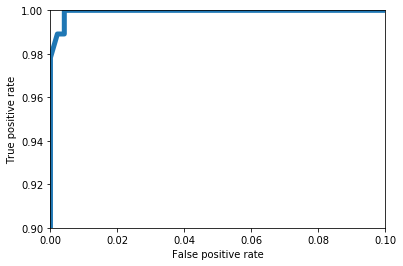

In [76]:
import matplotlib.pyplot as plt

y_scores = spam_clf.decision_function(corpus)

# Hack because of scikitlearn 0.19
if y_scores.ndim == 2:
    y_scores = y_scores[:, 1]

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(spam, y_scores)

def plot_roc_curve(fpr, tpr, label="foo"):
    plt.plot(fpr, tpr, linewidth=5, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 0.1, 0.9, 1])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    
plot_roc_curve(fpr, tpr)
plt.show()

Our ROC AUC is too good to make any compromise!

## 4.2 Confusion Matrix

In [81]:
from sklearn.metrics import confusion_matrix
confusion_matrix(spam, y_pred)

array([[483,   0],
       [  2,  90]])

Maybe if we had more emails, we would have more classification errors, and we could give a look at the ROC in order to fine-tune the precision recall compromise.

But so far so good.